In [1]:
# PROCESS THE GLOBULAR CLUSTER STARS CATAOLOG:
# https://zenodo.org/records/4549398
#
#
# ZACK REEVES
# CREATED: 2024
#
# VERSIONS:
#  1.1  JAN 2024 CREATE JUPYTER NOTEBOOK

In [14]:
import pandas as pd
import numpy as np
import sys
import os
import collections

from astropy.io import ascii
import astropy.units as u
import astropy.coordinates
from astropy.table import unique, vstack, Table, join

from astroquery.gaia import Gaia

sys.path.insert(0, '..')
from common import file_functions, calculations, gaia_functions, get_bailer_jones

from matplotlib import pyplot as plt, colors

In [4]:
# Define the metadata for the data set. #FIX LATER
metadata = {}

metadata['project'] = 'Digital Universe Atlas Gaia Subsets'
metadata['sub_project'] = 'Gaia Stars in Globular Clusters'

metadata['catalog'] = 'Catalogue of stars in Milky Way globular clusters from Gaia EDR3 (Vasiliev+, 2021)'
metadata['catalog_author'] = 'Vasiliev+'
metadata['catalog_year'] = '2021'
metadata['catalog_doi'] = 'https://doi.org/10.5281/zenodo.4891252'
metadata['catalog_bibcode'] = '10.5281/zenodo.4891252'

metadata['prepared_by'] = 'Brian Abbott, Zack Reeves'
metadata['version'] = '1.1'

metadata['dir'] = metadata['sub_project'].replace(' ', '_').lower()
metadata['raw_data_dir'] = ''

metadata['data_group_title'] = 'Gaia Globular Cluster Stars'
metadata['data_group_desc'] = 'Stars in the Milky Way identified to be members of globular clusters'
metadata['data_group_desc_long'] = ''
metadata['fileroot'] = 'globstars'

file_functions.generate_license_file(metadata)
file_functions.generate_asset_file(metadata)

In [4]:
#download data from https://zenodo.org/records/4549398

In [5]:
#reading in the data

#data are downloaded in a .zip file.  Once extracted, the stars associated with each cluster are stored in folders
#named by the cluster.  We combine each of these folders into one table with an appended column describing the
#cluster

#iterate through files in catalogues directory and stack

directory_str = 'raw_data/clusters/catalogues/'
directory = os.fsencode(directory_str)
    
tables=[]
for file in os.listdir(directory):
    filename = os.fsdecode(file)
    if filename.endswith(".txt"):
        #reading in the table
        table = ascii.read(directory_str+filename)
        #adding a column with the cluster name
        table['cluster_name'] = table.Column(data=[filename[:len(filename)-4]]*len(table),
                                             meta = collections.OrderedDict([('ucd', 'meta.name.cluster')]),
                                             description='Name of associated Globular Cluster')
        #adding table to array for stacking
        tables.append(table)

In [6]:
#combining tables in tables array
data = vstack(tables)
data

source_id,ra,dec,x,y,plx,pmra,pmdec,plxe,pmrae,pmdece,pmcorr,g_mag,bp_rp,Sigma,qflag,memberprob,cluster_name
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,str15
4061099905856448640,265.89028,-26.260536,-0.0319,-0.038,-1.2986,4.5868,0.6804,0.6658,0.8421,0.4172,0.3413,19.9038,nan,177.4,0,0.0,Pal_6
4061099901464585600,265.893652,-26.26247,-0.0289,-0.04,0.0694,-1.2504,1.1779,0.1059,0.1148,0.0673,0.306,16.9928,2.6678,177.2,1,0.0,Pal_6
4061099905824621440,265.89373,-26.261994,-0.0288,-0.0395,1.2915,-1.6526,1.5607,0.9233,1.0319,0.5829,0.3863,20.1845,nan,176.7,0,0.0,Pal_6
4061099905824608256,265.894464,-26.26215,-0.0281,-0.0397,0.812,5.8136,-0.7642,0.6132,0.8161,0.4178,0.515,19.7439,2.6454,176.3,0,0.0,Pal_6
4061099905824667264,265.8922,-26.26064,-0.0302,-0.0381,-0.3773,-2.7018,-6.4447,0.5729,0.67,0.3588,0.3689,19.7012,nan,176.3,0,0.0,Pal_6
4061099905824677504,265.892217,-26.26009,-0.0301,-0.0376,-0.2833,-0.1724,-1.5015,0.1673,0.1803,0.1072,0.2799,18.0677,2.6741,175.3,0,0.0,Pal_6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5932641800735066368,242.66848,-53.808635,0.0257,-0.0598,0.4061,-3.3361,-4.8417,0.0524,0.0609,0.0456,-0.0088,16.3329,1.1275,130.5,3,0.0,FSR_1716
5932641800719385856,242.669882,-53.809369,0.0265,-0.0605,1.5567,-4.5898,-2.5897,0.7437,0.8692,0.5802,0.1929,20.0783,1.6248,130.3,2,0.0,FSR_1716


In [7]:
#renaming columns 'x' and 'y' to not be confused with cartesian x and y and adding clarification
data.rename_column('x', 'cluster_x')
data['cluster_x'].description ='X coordinate centered on cluster'
data.rename_column('y', 'cluster_y')
data['cluster_y'].description ='Y coordinate centered on cluster'

#removing proper motion columns because we'll get them from Gaia DR3
data.remove_column('pmra')
data.remove_column('pmdec')

#removing rows with parallax <=0.0 and rows with memberprob < 0.5
data.remove_rows(np.where(data['plx']<=0.0)[0])
data.remove_rows(np.where(data['memberprob']<0.5)[0])

In [8]:
distances = get_bailer_jones.get_bj_distances(data, get_motion=True)

INFO: Login to gaia TAP server [astroquery.gaia.core]
OK
INFO: Login to gaia data server [astroquery.gaia.core]
OK
Sending pytable.
Uploaded table 'gaia_ids'.
INFO: Query finished. [astroquery.utils.tap.core]
Table 'gaia_ids' deleted.
Removed jobs: '1721417509258O'.
INFO: Gaia TAP server logout OK [astroquery.gaia.core]
INFO: Gaia data server logout OK [astroquery.gaia.core]


source_id,parallax,parallax_error,pmra,pmdec,radial_velocity,r_med_geo,r_hi_geo,r_lo_geo,r_med_photogeo,r_hi_photogeo,r_lo_photogeo,bj_distance,dcalc,e_bj_dist,bj_error_over_distance
,mas,mas,mas / yr,mas / yr,km / s,pc,pc,pc,pc,pc,pc,pc,,pc,
int64,float64,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,int64,float64,float64
4061099901464585600,0.02670369672864031,0.105942525,-1.2504279093284736,1.1779404464270447,--,8666.618,10692.805,5580.107,5159.831,5677.92,4518.6562,5159.831,1,579.6318359375,0.1123354291631172
4061099905824621440,1.2973823183295672,0.92330104,-1.6526281847233937,1.5606961388337328,--,6688.9263,10325.736,2409.031,--,--,--,6688.9263,2,3958.3525390625,0.5917769727995366
4061099905824608256,0.8084811083861558,0.6132075,5.813645812909807,-0.7641820639049138,--,5175.926,10493.553,2101.6338,6763.392,10008.755,4144.801,6763.392,1,2931.97705078125,0.43350688705214274
4061099905824637696,0.45624383812677166,0.5830215,1.6550027924623558,2.280237440676909,--,6898.625,9520.263,3488.346,--,--,--,6898.625,2,3015.95849609375,0.43718255392831906
4061099734025422464,7.754085246590259,0.10828306,-24.022702227555975,-45.390802187674936,--,128.61214,130.24435,126.78708,128.46065,169.70335,126.44942,128.61214,2,1.7286376953125,0.013440704258354615
4061099734025388288,0.6513223615171027,0.3641354,1.9094018450519825,-0.2631656589270062,--,3261.9631,5775.914,1684.1442,--,--,--,3261.9631,2,2045.885009765625,0.6271943995812889
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5932641800735066368,0.37361136807694556,0.05239922,-3.336080552573862,-4.841736560713912,--,2632.1445,3048.5605,2314.5151,2634.1997,3027.7678,2306.1677,2634.1997,1,360.800048828125,0.13696761405943197


In [16]:
data = join(data, distances, keys='source_id', join_type='left')
data

source_id,ra,dec,cluster_x,cluster_y,plx,pmra_1,pmdec_1,plxe,pmrae,pmdece,pmcorr,g_mag,bp_rp,Sigma,qflag,memberprob,cluster_name,parallax,parallax_error,pmra_2,pmdec_2,radial_velocity,r_med_geo,r_hi_geo,r_lo_geo,r_med_photogeo,r_hi_photogeo,r_lo_photogeo,bj_distance,dcalc,e_bj_dist,bj_error_over_distance
,,,,,,,,,,,,,,,,,,mas,mas,mas / yr,mas / yr,km / s,pc,pc,pc,pc,pc,pc,pc,,pc,
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,str15,float64,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,int64,float64,float64
159501173974695040,71.500024,31.340713,-0.021,-0.0408,0.1351,0.1192,-0.4298,0.4458,0.5656,0.4462,-0.0203,19.7151,1.953,4.657,2,0.07281,Pal_2,0.12768036142397277,0.44576532,0.11920412278314821,-0.4298329486734313,--,2333.6038,3373.1055,1577.9764,2534.1936,4148.792,2113.3784,2534.1936,1,1017.706787109375,0.40158999126883405
159501173976108800,71.50677,31.334577,-0.0152,-0.0469,0.3539,-0.7923,-3.6923,0.1176,0.1428,0.1074,-0.0551,17.6068,2.2672,3.622,3,0.0,Pal_2,0.3182997498107481,0.11759559,-0.7923206205820491,-3.6923082506947584,--,2932.0498,4108.341,2183.0881,2864.1785,3533.2698,2071.6306,2864.1785,1,730.819580078125,0.25515853448037046
159501410197793024,71.553766,31.351266,0.0249,-0.0302,0.2872,0.4022,-0.6216,0.1713,0.206,0.1661,0.1508,18.3064,1.5968,7.279,3,0.0,Pal_2,0.2643854243999901,0.17133845,0.40216100985646097,-0.6216025544204147,--,3123.5713,4208.3145,2278.1565,2434.8438,3151.3345,1984.9878,2434.8438,1,583.17333984375,0.23951160720015402
159501410198203520,71.557352,31.350691,0.028,-0.0308,1.3499,-2.1602,-2.0603,0.9348,1.314,0.9188,-0.1262,20.5106,1.7709,6.25,0,0.08633,Pal_2,1.3290337740870308,0.9347665,-2.160230345567209,-2.060295499878405,--,1430.2583,2281.1526,841.69055,3976.772,4894.6694,3384.5813,3976.772,1,755.0440673828125,0.18986355581219996
159501414494416640,71.551893,31.34754,0.0233,-0.034,0.5344,1.4042,-5.0897,0.1543,0.1859,0.1499,0.1327,18.1464,2.0384,6.422,3,0.0,Pal_2,0.5074544120307468,0.15430592,1.404191238125196,-5.089724660153631,--,2045.465,2815.5466,1610.128,1632.1719,2224.665,1284.6782,1632.1719,1,469.993408203125,0.2879558307565648
159501444557539584,71.562553,31.357862,0.0324,-0.0236,0.3906,-0.2901,-0.9531,0.1139,0.136,0.1072,0.2278,17.6614,2.0441,6.876,3,0.0,Pal_2,0.3585604654243742,0.113894306,-0.29012691782437955,-0.9531025814606751,--,2551.8289,3356.7834,2023.6658,2277.6482,2974.2783,1831.4939,2277.6482,1,571.3922119140625,0.25086938956595317
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6889504984511453696,313.410931,-12.450324,0.0444,0.087,1.8727,14.1215,-4.4943,0.2655,0.3185,0.185,-0.1714,18.7082,2.4213,3.396,3,0.0,NGC_6981_M_72,1.8522970466087743,0.26548946,14.121495362076754,-4.494316101797142,--,542.38055,614.2465,480.12646,594.3714,669.33954,516.16064,594.3714,1,76.58944702148438,0.1288578945082249


In [125]:
data['cluster_name'] = table.Column(data=data['cluster_name'],
                                         meta = collections.OrderedDict([('ucd', 'meta.name.cluster')]),
                                         description='Name of associated Globular Cluster')

In [17]:
#fixing parallax units
data['plx'].unit=u.mas

#fixing RA/Dec units
data['ra'].unit=u.deg
data['dec'].unit=u.deg

In [18]:
#calculating distance in light years and parsecs
calculations.get_distance(data, dist='bj_distance', use='distance')

In [19]:
#calculating cartesian coordinates
calculations.get_cartesian(data, ra='ra', dec='dec', pmra='pmra', pmde='pmdec', frame='icrs')

<function matplotlib.pyplot.show(close=None, block=None)>

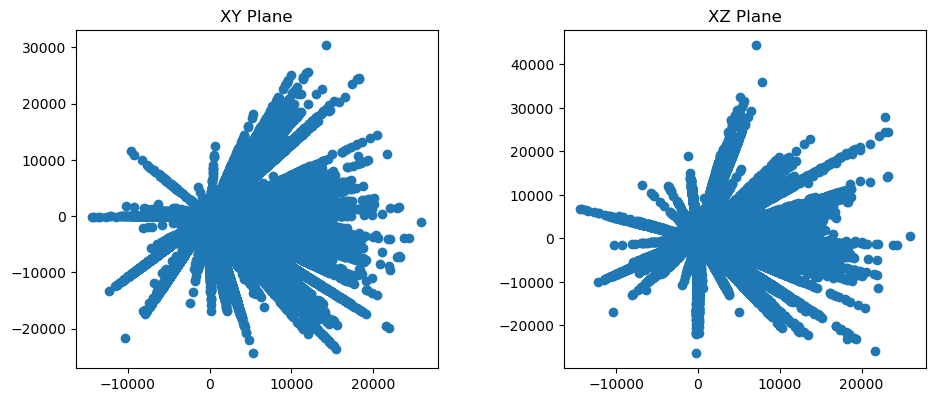

In [20]:
#2D Visualization
fig, ax = plt.subplots(1, 2)

#XY Plane
ax[0].scatter(data['x'], data['y'])
ax[0].set_title('XY Plane')

#XZ Plane
ax[1].scatter(data['x'], data['z'])
ax[1].set_title('XZ Plane')

#set good spacing
fig.tight_layout()
fig.set_size_inches(10, 4, forward=True)
plt.show

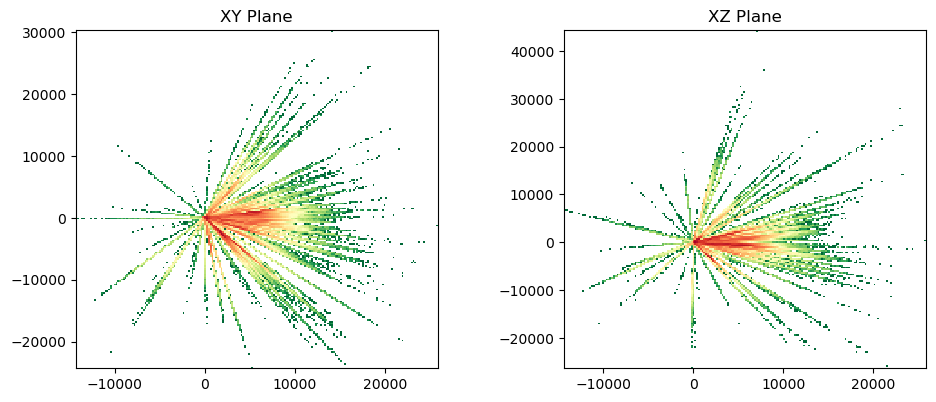

In [21]:
#2D Density Visualization
fig, ax = plt.subplots(1, 2)

#XY Plane
ax[0].hist2d(data['x'], data['y'], 
           bins = 200,  
           norm = colors.LogNorm(),  
           cmap = "RdYlGn_r",) 
ax[0].set_title('XY Plane')

#XZ Plane
ax[1].hist2d(data['x'], data['z'], 
           bins = 200,  
           norm = colors.LogNorm(),  
           cmap = "RdYlGn_r",) 
ax[1].set_title('XZ Plane')

#set good spacing
fig.tight_layout()
fig.set_size_inches(10, 4, forward=True)
#plt.show

In [34]:
len(data[data['memberprob']<0.5])

904726

In [35]:
data.remove_rows(np.where(data['memberprob']<0.5)[0])

In [29]:
#advised not to run this cell again, it's annoyingly long
cluster_names = unique(data, keys='cluster_name')['cluster_name']

In [31]:
for i in cluster_names:
    print(i)

AM_1
AM_4
Arp_2
BH_140
BH_176
BH_261_AL_3
Bliss_1
Crater
Djorg_1
Djorg_2_ESO456-
ESO280-06
ESO452-11
ESO_93-8
E_3
Eridanus
FSR_1716
FSR_1735
FSR_1758
Gran_1
HP_1_BH_229
IC_1257
IC_1276_Pal_7
IC_4499
Kim_3
Ko_1
Ko_2
Laevens_3
Liller_1
Lynga_7_BH184
Mercer_5
Munoz_1
NGC_104_47Tuc
NGC_1261
NGC_1851
NGC_1904_M_79
NGC_2298
NGC_2419
NGC_2808
NGC_288
NGC_3201
NGC_362
NGC_4147
NGC_4372
NGC_4590_M_68
NGC_4833
NGC_5024_M_53
NGC_5053
NGC_5139_oCen
NGC_5272_M_3
NGC_5286
NGC_5466
NGC_5634
NGC_5694
NGC_5824
NGC_5897
NGC_5904_M_5
NGC_5927
NGC_5946
NGC_5986
NGC_6093_M_80
NGC_6101
NGC_6121_M_4
NGC_6139
NGC_6144
NGC_6171_M107
NGC_6205_M_13
NGC_6218_M_12
NGC_6229
NGC_6235
NGC_6254_M_10
NGC_6256
NGC_6266_M_62
NGC_6273_M_19
NGC_6284
NGC_6287
NGC_6293
NGC_6304
NGC_6316
NGC_6325
NGC_6333_M_9
NGC_6341_M_92
NGC_6342
NGC_6352
NGC_6355
NGC_6356
NGC_6362
NGC_6366
NGC_6380_Ton1
NGC_6388
NGC_6397
NGC_6401
NGC_6402_M_14
NGC_6426
NGC_6440
NGC_6441
NGC_6453
NGC_6496
NGC_6517
NGC_6522
NGC_6528
NGC_6535
NGC_6539
NGC_654

<function matplotlib.pyplot.show(close=None, block=None)>

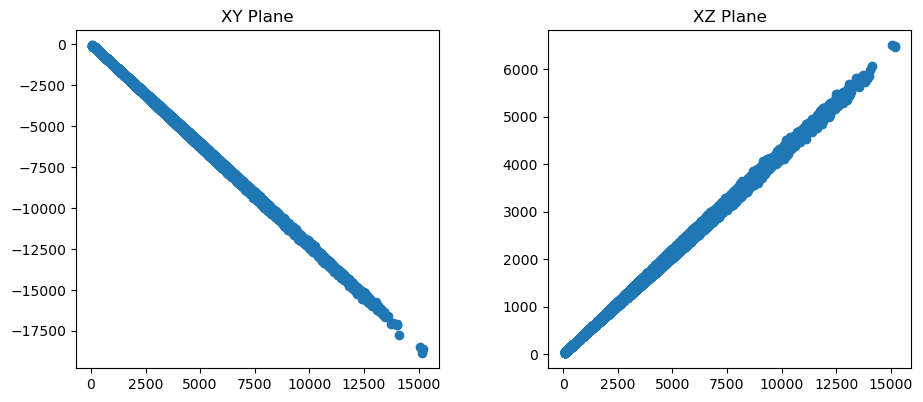

In [99]:
#case study on one cluster for data analysis
df = data[data['cluster_name']=='NGC_5139_oCen']

#2D Visualization
fig, ax = plt.subplots(1, 2)

#XY Plane
ax[0].scatter(df['x'], df['y'])
ax[0].set_title('XY Plane')

#XZ Plane
ax[1].scatter(df['x'], df['z'])
ax[1].set_title('XZ Plane')

#set good spacing
fig.tight_layout()
fig.set_size_inches(10, 4, forward=True)
plt.show

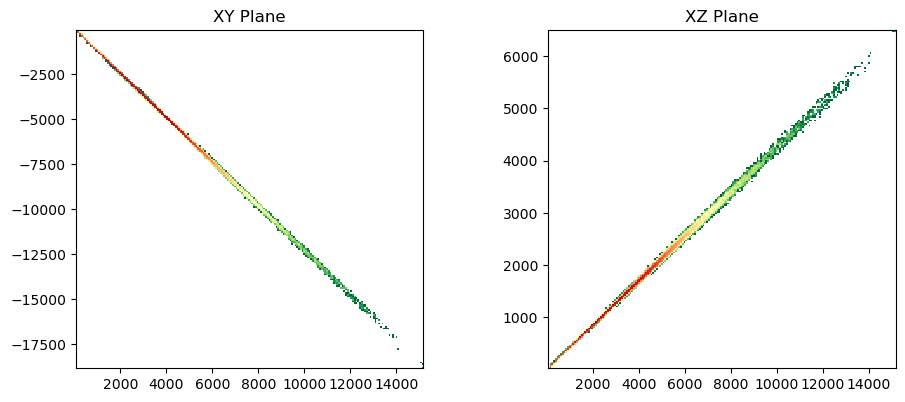

In [43]:
#2D Density Visualization
fig, ax = plt.subplots(1, 2)

#XY Plane
ax[0].hist2d(df['x'], df['y'], 
           bins = 200,  
           norm = colors.LogNorm(),  
           cmap = "RdYlGn_r",) 
ax[0].set_title('XY Plane')

#XZ Plane
ax[1].hist2d(df['x'], df['z'], 
           bins = 200,  
           norm = colors.LogNorm(),  
           cmap = "RdYlGn_r",) 
ax[1].set_title('XZ Plane')

#set good spacing
fig.tight_layout()
fig.set_size_inches(10, 4, forward=True)
#plt.show

In [44]:
calculations.get_distance(df, dist='bj_distance', use='distance')
calculations.get_cartesian(df, ra='ra', dec='dec', pmra='pmra', pmde='pmdec', frame='icrs')

In [45]:
sum(df['r_med_geo'])/len(df['r_med_geo'])

3437.9389108372466

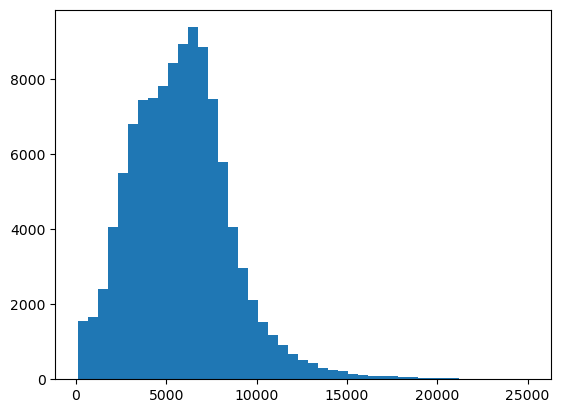

In [46]:
plt.hist(df['bj_distance'], bins=45);

In [122]:
#construct a speck comment column
data['speck_label'] = data.Column(data=['#__'+str(name) for name in data['source_id']], 
                                  meta=collections.OrderedDict([('ucd', 'meta.id')]),
                                  description='Gaia EDR3 Source ID')

#construct a label column
data['label'] = ['GaiaEDR3_'+ str(source) for source in data['source_id']]  #leaving for now in case we want to add other labels

In [48]:
from astroquery.vizier import Vizier
#reading in the catalogue
catalog = Vizier(catalog='J/MNRAS/505/5978', columns=['**'], row_limit=-1).query_constraints()
clusters = catalog[0]

In [50]:
clusters['dist_pc'] = clusters['plx'].to(unit=u.pc, equivalencies=u.parallax())

In [56]:
clusters[clusters['Name']=='NGC 5139']

recno,Name,OName,RAJ2000,DEJ2000,pmRA,e_pmRA,pmDE,e_pmDE,corr,plx,e_plx,Rscale,Nstar,SimbadName,dist_pc
,,,deg,deg,mas / yr,mas / yr,mas / yr,mas / yr,,mas,mas,arcmin,,,pc
int32,str12,str10,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,str26,float32
34,NGC 5139,omega Cen,201.697,-47.480,-3.250,0.022,-6.746,0.022,0.01,0.193,0.009,14.62,53127,NGC 5139,5181.347


In [55]:
[i for i in clusters['Name'] if '5139' in i]

['NGC 5139']

In [72]:
def angle_radius(rscale_theta, distance):
    return distance*np.tan(rscale_theta)

In [73]:
angle_radius(rscale_theta=14.62*u.arcmin, distance=5181.347*u.pc).to(u.lyr)

<Quantity 71.86950633 lyr>

In [61]:
np.tan(14.62*u.arcmin)

<Quantity 0.00425281>

In [60]:
(14.62*u.arcmin).to(u.rad)

<Quantity 0.00425279 rad>

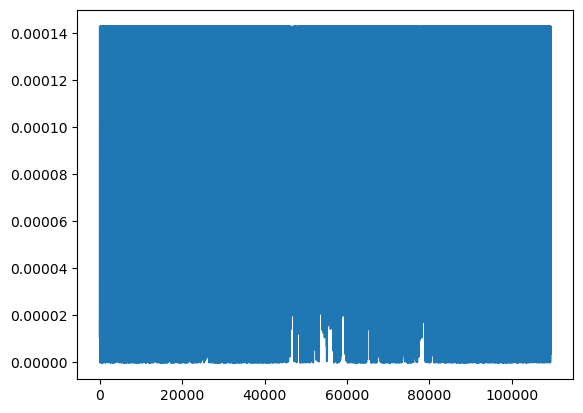

In [66]:
# from scipy.stats import norm
# s = np.std(df['bj_distance'])
# m = np.mean(df['bj_distance'])
# plt.plot(norm.pdf(df['bj_distance'],m,s))

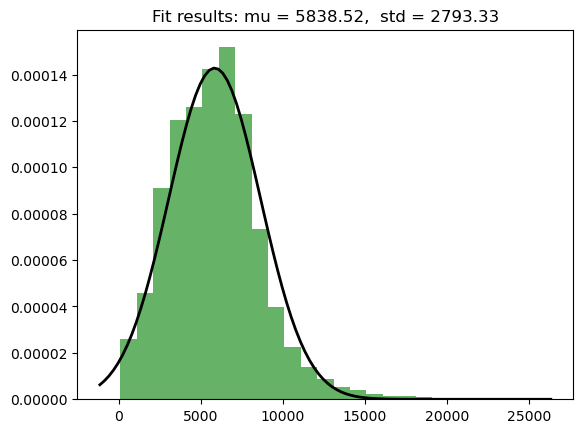

In [100]:
mu, std = norm.fit(df['bj_distance'])

# Plot the histogram.
plt.hist(df['bj_distance'], bins=25, density=True, alpha=0.6, color='g')

# Plot the PDF.
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)
plt.title(title)

plt.show()

In [101]:
import scipy.stats as stats
stats.percentileofscore(df['bj_distance'], 5838, kind='weak')

51.31371062749431

In [102]:
df['dist_percentile'] = [stats.percentileofscore(df['bj_distance'], df['bj_distance'][i], kind='weak') for i in range(len(df))]

In [103]:
df

source_id,ra,dec,cluster_x,cluster_y,plx,plxe,pmrae,pmdece,pmcorr,g_mag,bp_rp,Sigma,qflag,memberprob,cluster_name,parallax,parallax_error,pmra,pmdec,radial_velocity,r_med_geo,r_hi_geo,r_lo_geo,r_med_photogeo,r_hi_photogeo,r_lo_photogeo,bj_distance,dcalc,e_bj_dist,bj_error_over_distance,dist_pc,dist_ly,x,y,z,color,dist_percentile
,deg,deg,,,mas,,,,,,,,,,,mas,mas,mas / yr,mas / yr,km / s,pc,pc,pc,pc,pc,pc,pc,,pc,,pc,lyr,pc,pc,pc,solLum,
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,str15,float64,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,int64,float64,float64,float32,float32,float64,float64,float64,float64,float64
6083434494585003648,201.950292,-48.116956,0.1692,-0.6376,2.0093,2.2404,2.8238,1.4221,0.0541,20.7079,1.4867,13.62,0,0.83068,NGC_5139_oCen,1.9525315380648003,2.240424,-4.435728134790734,-8.822759805186294,--,3401.624,5532.024,1517.0328,5691.709,6404.3525,4976.1626,5691.709,1,714.094970703125,0.12546231240273767,5691.708984,18563.9,3484.293299,-4274.963815,1407.101898,1.49,49.18949031498004
6083434524649608960,201.970508,-48.098111,0.1828,-0.6188,0.5796,0.9495,0.6967,0.6417,-0.0504,20.1668,0.9413,14.0,3,0.8879,NGC_5139_oCen,0.5689398546181611,0.94945395,-4.577009207735635,-5.935721860264544,--,2740.9624,4216.4824,1494.696,10527.81,12722.877,8901.599,10527.81,1,1910.63916015625,0.18148496583221688,10527.809570,34337.1,6446.621605,-7904.835695,2605.650947,0.94,94.92506780883843
6083434528963063040,201.959572,-48.104106,0.1755,-0.6248,0.7302,1.5747,0.9576,1.0252,-0.2273,20.4283,1.181,13.9,2,0.96816,NGC_5139_oCen,0.7324088499938591,1.5746613,-2.4066618353870823,-7.110639610978466,--,4036.9917,6876.6533,1885.1216,7668.336,8986.484,6266.323,7668.336,1,1360.08056640625,0.17736319554743685,7668.335938,25010.8,4694.907397,-5758.601643,1897.294836,1.18,77.92034630453246
6083434769477588736,202.031474,-48.098593,0.2235,-0.6195,0.1469,0.2237,0.2151,0.1754,-0.0842,18.5881,0.82,13.65,3,0.99789,NGC_5139_oCen,0.12252884469614513,0.22367418,-3.83051171619488,-6.8131854156822715,--,3677.3,5082.4204,2486.4558,6825.0586,8180.7974,5691.8604,6825.0586,1,1244.468505859375,0.18233814241521507,6825.058594,22260.4,4183.101561,-5121.732656,1688.472902,0.82,66.28918985561512
6083434803837514624,202.050473,-48.077283,0.2363,-0.5982,0.0527,1.1159,1.201,1.1992,-0.0757,20.5897,1.5236,14.06,2,0.96957,NGC_5139_oCen,0.00927229907989226,1.1159174,-3.3904891556456134,-7.367015093904799,--,2842.5237,5728.492,1510.843,5226.945,6004.2627,4567.777,5226.945,1,718.242919921875,0.13741161310789765,5226.944824,17048.0,3204.445178,-3921.218215,1294.809253,1.52,42.689887578881994
6083435005693180160,202.041072,-48.064754,0.2301,-0.5857,1.1842,2.5412,1.4333,1.6484,-0.2023,20.6323,1.2224,14.33,1,0.76515,NGC_5139_oCen,1.1771523255861869,2.5412204,-2.527284985166209,-5.188279783883379,--,3049.5747,5044.986,1208.2157,8034.619,9349.427,6748.1206,8034.619,1,1300.653076171875,0.16188111140146705,8034.619141,26205.4,4924.957696,-6027.546270,1992.130116,1.22,81.97152485410825
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6086767316194513536,201.101096,-46.96848,-0.4065,0.5095,0.2651,0.3729,0.4101,0.3491,0.1427,19.6379,2.2718,13.83,2,0.99291,NGC_5139_oCen,0.2752244441439972,0.3728882,-3.5899504839076166,-6.426025939697756,--,3690.3062,5624.103,2164.5198,1401.8315,1621.0947,1187.5269,1401.8315,1,216.783935546875,0.15464335685283379,1401.831543,4572.2,845.571013,-1053.218663,375.328904,2.27,3.5114475931287044


In [114]:
#mu is the desired distance and sigma will be the adjusted stdev
mu = 5181.347
#we want 95% of our stars within our calculated diameter, so 2*sigma=diameter
sigma = angle_radius(rscale_theta=14.62*u.arcmin, distance=5181.347*u.pc)

adjusted_distance_distribution = stats.norm(loc=mu, scale=sigma)

df['adjusted_distances'] = [adjusted_distance_distribution.ppf(i/100)*u.pc for i in df['dist_percentile']]

In [116]:
calculations.get_distance(df, dist='adjusted_distances', use='distance')
calculations.get_cartesian(df, ra='ra', dec='dec', pmra='pmra', pmde='pmdec', frame='icrs')

/Users/zackreeves/anaconda3/lib/python3.11/site-packages/astropy/units/quantity.py:666: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/zackreeves/anaconda3/lib/python3.11/site-packages/astropy/units/quantity.py:666: RuntimeWarning: invalid value encountered in add
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/zackreeves/anaconda3/lib/python3.11/site-packages/astropy/units/quantity.py:666: RuntimeWarning: invalid value encountered in rxp
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


<function matplotlib.pyplot.show(close=None, block=None)>

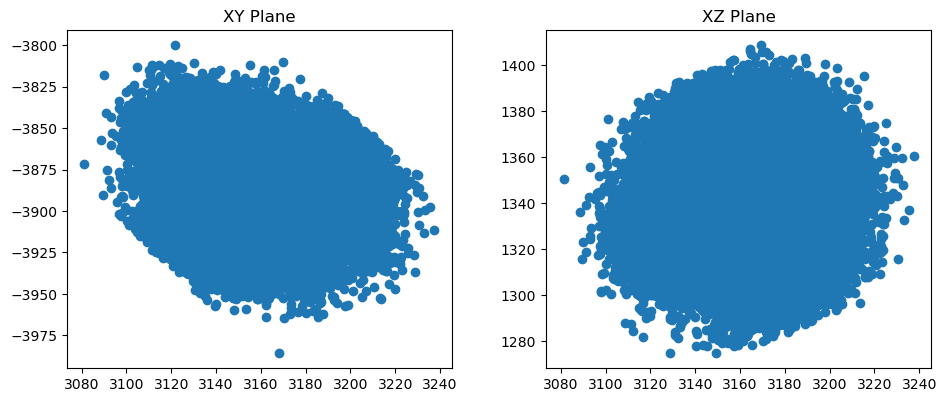

In [117]:


#2D Visualization
fig, ax = plt.subplots(1, 2)

#XY Plane
ax[0].scatter(df['x'], df['y'])
ax[0].set_title('XY Plane')

#XZ Plane
ax[1].scatter(df['x'], df['z'])
ax[1].set_title('XZ Plane')

#set good spacing
fig.tight_layout()
fig.set_size_inches(10, 4, forward=True)
plt.show

In [118]:
df

source_id,ra,dec,cluster_x,cluster_y,plx,plxe,pmrae,pmdece,pmcorr,g_mag,bp_rp,Sigma,qflag,memberprob,cluster_name,parallax,parallax_error,pmra,pmdec,radial_velocity,r_med_geo,r_hi_geo,r_lo_geo,r_med_photogeo,r_hi_photogeo,r_lo_photogeo,bj_distance,dcalc,e_bj_dist,bj_error_over_distance,dist_pc,dist_ly,x,y,z,color,dist_percentile,adjusted_distances,u,v,w,speed,appmag,absmag,lum,texnum
,deg,deg,,,mas,,,,,,,,,,,mas,mas,mas / yr,mas / yr,km / s,pc,pc,pc,pc,pc,pc,pc,,pc,,pc,lyr,pc,pc,pc,solLum,,pc,km / s,km / s,km / s,,mag,mag,solLum,
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,str15,float64,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64
6083434494585003648,201.950292,-48.116956,0.1692,-0.6376,2.0093,2.2404,2.8238,1.4221,0.0541,20.7079,1.4867,13.62,0,0.83068,NGC_5139_oCen,1.9525315380648003,2.240424,-4.435728134790734,-8.822759805186294,--,3401.624,5532.024,1517.0328,5691.709,6404.3525,4976.1626,5691.709,1,714.094970703125,0.12546231240273767,5180.899290,16897.8,3171.590945,-3891.301726,1280.819741,1.49,49.18949031498004,5180.899289985249,nan,nan,nan,nan,20.707900,nan,nan,1
6083434524649608960,201.970508,-48.098111,0.1828,-0.6188,0.5796,0.9495,0.6967,0.6417,-0.0504,20.1668,0.9413,14.0,3,0.8879,NGC_5139_oCen,0.5689398546181611,0.94945395,-4.577009207735635,-5.935721860264544,--,2740.9624,4216.4824,1494.696,10527.81,12722.877,8901.599,10527.81,1,1910.63916015625,0.18148496583221688,5217.432680,17017.0,3194.853974,-3917.524136,1291.323548,0.94,94.92506780883843,5217.432680437507,nan,nan,nan,nan,20.166800,nan,nan,1
6083434528963063040,201.959572,-48.104106,0.1755,-0.6248,0.7302,1.5747,0.9576,1.0252,-0.2273,20.4283,1.181,13.9,2,0.96816,NGC_5139_oCen,0.7324088499938591,1.5746613,-2.4066618353870823,-7.110639610978466,--,4036.9917,6876.6533,1885.1216,7668.336,8986.484,6266.323,7668.336,1,1360.08056640625,0.17736319554743685,5198.303285,16954.6,3182.639982,-3903.709760,1286.160917,1.18,77.92034630453246,5198.303285153004,nan,nan,nan,nan,20.428300,nan,nan,1
6083434769477588736,202.031474,-48.098593,0.2235,-0.6195,0.1469,0.2237,0.2151,0.1754,-0.0842,18.5881,0.82,13.65,3,0.99789,NGC_5139_oCen,0.12252884469614513,0.22367418,-3.83051171619488,-6.8131854156822715,--,3677.3,5082.4204,2486.4558,6825.0586,8180.7974,5691.8604,6825.0586,1,1244.468505859375,0.18233814241521507,5190.609944,16929.5,3181.342440,-3895.192413,1284.121464,0.82,66.28918985561512,5190.609944349071,nan,nan,nan,nan,18.588100,nan,nan,1
6083434803837514624,202.050473,-48.077283,0.2363,-0.5982,0.0527,1.1159,1.201,1.1992,-0.0757,20.5897,1.5236,14.06,2,0.96957,NGC_5139_oCen,0.00927229907989226,1.1159174,-3.3904891556456134,-7.367015093904799,--,2842.5237,5728.492,1510.843,5226.945,6004.2627,4567.777,5226.945,1,718.242919921875,0.13741161310789765,5177.286448,16886.0,3174.001477,-3883.964841,1282.507971,1.52,42.689887578881994,5177.28644752741,nan,nan,nan,nan,20.589700,nan,nan,1
6083435005693180160,202.041072,-48.064754,0.2301,-0.5857,1.1842,2.5412,1.4333,1.6484,-0.2023,20.6323,1.2224,14.33,1,0.76515,NGC_5139_oCen,1.1771523255861869,2.5412204,-2.527284985166209,-5.188279783883379,--,3049.5747,5044.986,1208.2157,8034.619,9349.427,6748.1206,8034.619,1,1300.653076171875,0.16188111140146705,5201.493435,16965.0,3188.344671,-3902.144184,1289.675533,1.22,81.97152485410825,5201.493435498024,nan,nan,nan,nan,20.632300,nan,nan,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6086767316194513536,201.101096,-46.96848,-0.4065,0.5095,0.2651,0.3729,0.4101,0.3491,0.1427,19.6379,2.2718,13.83,2,0.99291,NGC_5139_oCen,0.2752244441439972,0.3728882,-3.5899504839076166,-6.426025939697756,--,3690.3062,5624.103,216

In [119]:
df['appmag'] = df.MaskedColumn(data=df['g_mag'],
                                   unit=u.mag,
                                   meta=collections.OrderedDict([('ucd', 'phot.mag;em.opt.G')]),
                                   format='{:.6f}',
                                   description='Apparent magnitude in Gaia G-band')
df['absmag'] = df.MaskedColumn(data=[df['appmag'][i]+5-5*np.log10(df['dist_pc'][i]) for i in range(len(df))],
                             unit=u.mag,
                             meta=collections.OrderedDict([('ucd', 'phot.magAbs;em.opt.G')]),
                             format='{:.6f}',
                             description='Absolute magnitude in Gaia G-band')
gaia_functions.get_luminosity(df)
df['color'] = df.MaskedColumn(data=df['bp_rp'],
                                  unit=u.solLum,
                                  meta=collections.OrderedDict([('ucd', 'phys.color')]),
                                  format='{:.2f}',
                                  description='Gaia BP-G color')

In [120]:
#setting texture number column
df['texnum'] = df.Column(data=[1]*len(df), 
                                  meta=collections.OrderedDict([('ucd', 'meta.texnum')]),
                                  description='Texture Number')

In [145]:
list(df['dcalc'].meta.items())[0][1]

'meta.dist'

In [146]:
#Getting the column metadata
columns = file_functions.get_metadata(df, columns=['x', 'y', 'z', 'color', 'lum', 'absmag', 'appmag', 'texnum', 'dist_ly', 'dcalc', 'u', 'v', 'w', 'speed', 'cluster_name', 'speck_label'])
columns

,name,unit,datatype,width,precision,arraysize,ucd,description
0,x,pc,float64,,6,,pos.cartesian.x,x position (galactic cartesian coordinates) in...
1,y,pc,float64,,6,,pos.cartesian.y,y position (galactic cartesian coordinates) in...
2,z,pc,float64,,6,,pos.cartesian.z,z position (galactic cartesian coordinates) in...
3,color,solLum,float64,,2,,phys.color,Gaia BP-G color
4,lum,solLum,float64,,6,,phys.luminosity,Stellar Luminosity
5,absmag,mag,float64,,6,,phot.magAbs;em.opt.G,Absolute magnitude in Gaia G-band
6,appmag,mag,float64,,6,,phot.mag;em.opt.G,Apparent magnitude in Gaia G-band
7,texnum,,int64,,,,meta.texnum,Texture Number
8,dist_ly,lyr,float64,,1,,pos.distance,Distance from Sun (lyr)
9,dcalc,,int64,,,,meta.dist,Distance indicator: 1 indicates a Bailer-Jones...


In [97]:
df

source_id,ra,dec,cluster_x,cluster_y,plx,pmra_1,pmdec_1,plxe,pmrae,pmdece,pmcorr,g_mag,bp_rp,Sigma,qflag,memberprob,cluster_name,parallax,parallax_error,pmra_2,pmdec_2,radial_velocity,r_med_geo,r_hi_geo,r_lo_geo,r_med_photogeo,r_hi_photogeo,r_lo_photogeo,bj_distance,dcalc,e_bj_dist,bj_error_over_distance,dist_pc,dist_ly,x,y,z,dist_percentile,adjusted_distances,appmag,absmag,lum,color,texnum
,deg,deg,,,mas,,,,,,,,,,,,,mas,mas,mas / yr,mas / yr,km / s,pc,pc,pc,pc,pc,pc,pc,,pc,,pc,lyr,pc,pc,pc,,pc,mag,mag,solLum,solLum,
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,str15,float64,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64
6083434494585003648,201.950292,-48.116956,0.1692,-0.6376,2.0093,-4.4357,-8.8228,2.2404,2.8238,1.4221,0.0541,20.7079,1.4867,13.62,0,0.83068,NGC_5139_oCen,1.9525315380648003,2.240424,-4.435728134790734,-8.822759805186294,--,3401.624,5532.024,1517.0328,5691.709,6404.3525,4976.1626,5691.709,1,714.094970703125,0.12546231240273767,nan,nan,--,--,--,49.18949031498004,nan,20.707900,nan,nan,1.49,1
6083434524649608960,201.970508,-48.098111,0.1828,-0.6188,0.5796,-4.577,-5.9357,0.9495,0.6967,0.6417,-0.0504,20.1668,0.9413,14.0,3,0.8879,NGC_5139_oCen,0.5689398546181611,0.94945395,-4.577009207735635,-5.935721860264544,--,2740.9624,4216.4824,1494.696,10527.81,12722.877,8901.599,10527.81,1,1910.63916015625,0.18148496583221688,nan,nan,--,--,--,94.92506780883843,nan,20.166800,nan,nan,0.94,1
6083434528963063040,201.959572,-48.104106,0.1755,-0.6248,0.7302,-2.4067,-7.1106,1.5747,0.9576,1.0252,-0.2273,20.4283,1.181,13.9,2,0.96816,NGC_5139_oCen,0.7324088499938591,1.5746613,-2.4066618353870823,-7.110639610978466,--,4036.9917,6876.6533,1885.1216,7668.336,8986.484,6266.323,7668.336,1,1360.08056640625,0.17736319554743685,nan,nan,--,--,--,77.92034630453246,nan,20.428300,nan,nan,1.18,1
6083434769477588736,202.031474,-48.098593,0.2235,-0.6195,0.1469,-3.8305,-6.8132,0.2237,0.2151,0.1754,-0.0842,18.5881,0.82,13.65,3,0.99789,NGC_5139_oCen,0.12252884469614513,0.22367418,-3.83051171619488,-6.8131854156822715,--,3677.3,5082.4204,2486.4558,6825.0586,8180.7974,5691.8604,6825.0586,1,1244.468505859375,0.18233814241521507,nan,nan,--,--,--,66.28918985561512,nan,18.588100,nan,nan,0.82,1
6083434803837514624,202.050473,-48.077283,0.2363,-0.5982,0.0527,-3.3905,-7.367,1.1159,1.201,1.1992,-0.0757,20.5897,1.5236,14.06,2,0.96957,NGC_5139_oCen,0.00927229907989226,1.1159174,-3.3904891556456134,-7.367015093904799,--,2842.5237,5728.492,1510.843,5226.945,6004.2627,4567.777,5226.945,1,718.242919921875,0.13741161310789765,nan,nan,--,--,--,42.689887578881994,nan,20.589700,nan,nan,1.52,1
6083435005693180160,202.041072,-48.064754,0.2301,-0.5857,1.1842,-2.5273,-5.1883,2.5412,1.4333,1.6484,-0.2023,20.6323,1.2224,14.33,1,0.76515,NGC_5139_oCen,1.1771523255861869,2.5412204,-2.527284985166209,-5.188279783883379,--,3049.5747,5044.986,1208.2157,8034.619,9349.427,6748.1206,8034.619,1,1300.653076171875,0.16188111140146705,nan,nan,--,--,--,81.97152485410825,nan,20.632300,nan,nan,1.22,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6086767316194513536,201.101096,-46.96848,-0.4065,0.5095,0.2651,-3.5899,-6.426,0.3729,0.4101,0.3491,0.1427,19.6379,2.2718,13.83,2,0.99291,NGC_5139_oCen,0.2752244441439972,0.3728882,-3.5899504839076166,-6.426025939697756,--,3690.3062,5624.103,2164.5198,1401.8315,1621.0947,1187.5269,1401.8315,1,216.783935546875,0.15464335685283379,nan,nan,--,--,--,3.5114475931287044,nan,19.637900,nan,nan,2.27,1


In [147]:
# Print the csv file using the to_speck function in file_functions
file_functions.to_csv(metadata, Table.to_pandas(df), columns)

# Print the speck file using the to_speck function in file_functions
file_functions.to_speck(metadata, Table.to_pandas(df), columns)

# Print the label file using the to_label function in file_functions
file_functions.to_label(metadata, Table.to_pandas(df))